In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 200
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [2]:
data_log_reg = pd.read_csv('new_feat_train_small.csv', index_col ='match_id_hash')
target = pd.read_csv('train_targets.csv', index_col = 'match_id_hash')
y = target['radiant_win'].apply(lambda x: int(x))
data_log_reg.head(2)

,d_dead,r_dead,d_health_avg,r_health_avg,d1_in_r_base,r1_in_r_base,d1_in_d_base,r1_in_d_base,d2_in_r_base,r2_in_r_base,...,log_d_damage_received,log_r_max_hero_hit,log_d_max_hero_hit,log_chat_len,log_game_time,log_ratio_assists,sq_r_gold,sq_r_xp,sq_d_gold,sq_d_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0.954967,0.715500,0,0,0,0,0,0,...,7.349874,5.209486,6.042633,2.484907,5.049856,0.000000,4149369,3964081,15586704,9511056
b9c57c450ce74a2af79c9ce96fac144d,0,0,0.764778,0.846735,0,1,0,0,0,0,...,10.104794,6.877296,6.639876,2.397895,6.490724,1.504077,330221584,308564356,172764736,167055625


In [3]:
# select categorical and numerical columns
# categorical columns will be encoded
# numerical columns will be normalized

cat_feats = ['game_mode','lobby_type', 'r_firstblood_claimed','d_firstblood_claimed', 'r_in_r_base', 'd_in_d_base', 'r_in_d_base', 'd_in_r_base']
num_feats = [col for col in data_log_reg.columns if col not in cat_feats]
numerical_columns =[]
for j in range(len(data_log_reg.columns)):
    if data_log_reg.columns[j] in num_feats:
        numerical_columns.append(j)

## Building pipeline, Model tuning

In [4]:
from sklearn.model_selection import train_test_split

X_log_reg = data_log_reg

X_train, X_test, y_train, y_test = train_test_split(X_log_reg, y, test_size=0.30, random_state=150)
X_train.shape

(27772, 148)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

preprocess = make_column_transformer(
    (StandardScaler(), num_feats),
    (OneHotEncoder(),cat_feats))

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score,make_scorer


logreg = LogisticRegression(C = 10, penalty = 'l1' )
pipe = make_pipeline(preprocess, logreg)

In [6]:
# performing the grid search for optimal hyperparameters

auc_scorer = make_scorer(roc_auc_score, needs_proba = True)

from sklearn.model_selection import GridSearchCV
params_logred = {
    'logisticregression__C': [0.01,0.1,11,10, 100, 300],
    'logisticregression__penalty':['l1', 'l2'],      
                }

grid_clf = GridSearchCV(pipe, params_logred, cv=5, scoring = auc_scorer)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)
print("grid search best score: %f" % grid_clf.best_estimator_.score(X_test, y_test))

{'logisticregression__C': 10, 'logisticregression__penalty': 'l1'}
grid search best score: 0.757960


In [7]:
# fit the model on the training data
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['d_dead', 'r_dead',
                                                   'd_health_avg',
                                                   'r_health_avg',
                                                   'd1_in_r_base',
                                                   'r1_in_r_base',
                                                   'd1_in_d_base',
                                            

In [8]:
# model assesment: checking the accuracy on the test set

predicted_log_reg = pipe.predict(X_test)
print(accuracy_score(y_test, predicted_log_reg))
predicted_prob = pipe.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,predicted_prob))

0.7580441905402
0.8453644578100123


In [9]:
# fit the model on the full dataset
pipe.fit(X_log_reg,y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['d_dead', 'r_dead',
                                                   'd_health_avg',
                                                   'r_health_avg',
                                                   'd1_in_r_base',
                                                   'r1_in_r_base',
                                                   'd1_in_d_base',
                                            

Text(0, 0.5, 'coefficient of regression')

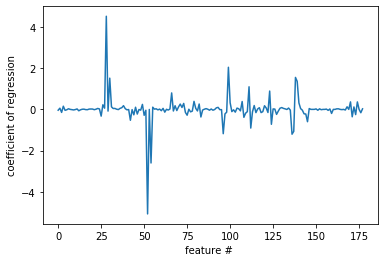

In [10]:
c = logreg.coef_
plt.plot(c[0])
plt.xlabel('feature # ')
plt.ylabel('coefficient of regression')

## Preparing submission file

In [11]:
# load test data (for submission)
test_data =  pd.read_csv('new_feat_test_small.csv', index_col ='match_id_hash')
X_sub_log_reg = test_data
y_test_pred_log_reg = pipe.predict_proba(X_sub_log_reg)[:, 1]

In [12]:
df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred_log_reg},index=test_data.index)

import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

df_submission.head(10)

Submission saved to submission_2019-11-24_22-30-31.csv


,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.289771
70e5ba30f367cea48793b9003fab9d38,0.982735
4d9ef74d3a2025d79e9423105fd73d41,0.951998
2bb79e0c1eaac1608e5a09c8e0c6a555,0.869946
bec17f099b01d67edc82dfb5ce735a43,0.200995
038acbb47d9eb54c11962d07cce8d829,0.074772
b891f03bb2a86d78b84043437fc95e04,0.961237
ff898afdb5bb5c7163bde45a009503f7,0.114191
72e6b1c31c718c0806f9aaeb8b7290a9,0.622756
